# **Multi Layer Perceptron (MLP) with one ReLU-activated hidden layer using CIFAR10 dataset**

In [2]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [4]:
class Cifar10(torchvision.datasets.CIFAR10):
  def __init__(self, train: bool):
    super().__init__(root='~/data', train=train, download=True)
    self.data = self.data.astype(np.float32) / 255 - 0.5

  def __getitem__(self, idx):
    return self.data[idx], self.targets[idx]

data_train = Cifar10(train=True)
data_train, data_valid = torch.utils.data.random_split(data_train, (45000, 5000))
data_test = Cifar10(train=False)

100%|██████████| 170498071/170498071 [00:07<00:00, 22739790.23it/s]


Extracting /root/data/cifar-10-python.tar.gz to /root/data
Files already downloaded and verified


In [5]:
kwargs = {'batch_size': 100, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(data_train, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(data_valid, **kwargs)
loader_test = torch.utils.data.DataLoader(data_test, **kwargs)

In [6]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None

In [7]:
# Model
class MyLayer(nn.Module):
  def __init__(self, n_hidden_neurons):
    super().__init__()
    # Flatten the image into a vector
    self.flatt = nn.Flatten()

    # Sequence: 32*32*3 -> n_hidden_neurons
    #           activation with ReLU
    #           n_hidden_neurons -> 10

    # First layer is Linear that takes 32*32 pictures with 3 channels for color and reduces to 100 (hidden neurons)
    self.layer1 = nn.Linear(in_features=32*32*3, out_features=n_hidden_neurons, bias=True)

    # We use an activation function so the model doesn't collapse
    self.activation = nn.ReLU()

    # Second layer goes from 100 to 10, 10 being the number of classes
    self.layer2 = nn.Linear(in_features=n_hidden_neurons, out_features=10, bias=True)

  def forward(self, x):
    x = self.flatt(x)
    layer1 = self.layer1(x)
    activation = self.activation(layer1)
    layer2 = self.layer2(activation)
    return layer2


In [8]:
device = torch.device('cuda')
n_hidden_neurons = 1000
# Call the model and add to device
model = MyLayer(n_hidden_neurons).to(device)
opt = torch.optim.SGD(model.parameters(), lr=5e-2)

train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in tqdm(range(50)):
  # train
  epoch_losses = []
  correct, total = 0, 0
  for x, y in loader_train:
    x, y = x.to(device), y.to(device)
    # Logits: common name for the output before softmax activation
    logits = model(x)
    # Numerically stable version of log(softmax(logits))
    log_probs = F.log_softmax(logits, dim=1)
    # Negative log likelihood loss
    loss = F.nll_loss(log_probs, y)
    # or just: loss = F.cross_entropy(logits, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    epoch_losses.append(loss.item())
    # Get total and correct to get the accuracy
    total += len(x)
    correct += (torch.argmax(logits, dim=1) == y).sum().item()
  train_loss = np.mean(epoch_losses)
  train_accuracy = correct / total


  # valid
  epoch_losses = []
  correct, total = 0, 0
  with torch.no_grad():
    for x, y in loader_valid:
      x, y = x.to(device), y.to(device)
      # Get output before softmax activation
      logits = model(x)
      # Get the log(softmax(logits))
      log_probs = F.log_softmax(logits, dim=1)
      # Get the negative log likelihood loss
      loss = F.nll_loss(log_probs, y)
      epoch_losses.append(loss.item())
      # Count total and correct to get the accuracy
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    valid_loss = np.mean(epoch_losses)
    valid_accuracy = correct / total


  if valid_accuracy > best_accuracy:
    best_accuracy = valid_accuracy
    best_model = copy.deepcopy(model), n_hidden_neurons, epoch

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accuracies.append(train_accuracy)
  valid_accuracies.append(valid_accuracy)

all_losses[n_hidden_neurons] = train_losses, valid_losses
all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies

  0%|          | 0/50 [00:00<?, ?it/s]

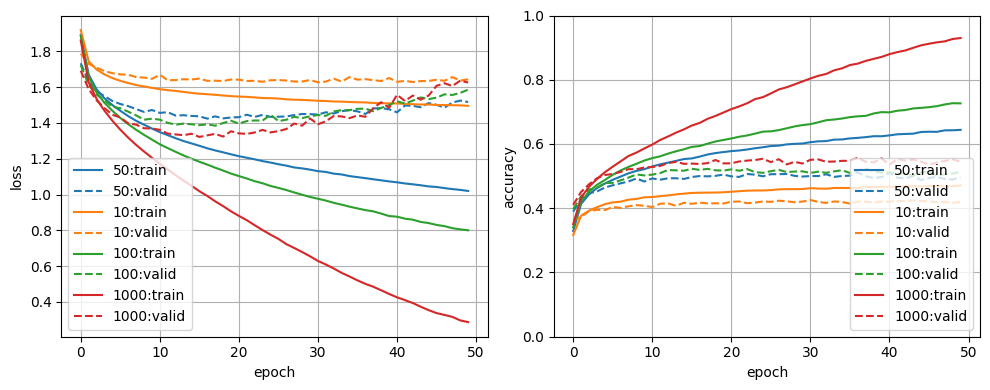

In [ ]:
# Plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# If there is a gap between the train and validation loss (graph 1), we can try to have less hidden neurons
# but we also need to keep the accuracy high

In [ ]:
model, n_hidden_neurons, epoch = best_model
print(f'best val accuracy: {best_accuracy:.2f} with {n_hidden_neurons} hidden neurons after {epoch} epoch')

# test
# TODO: evaluate accuracy on test set
model = model.to(device)
epoch_losses = []
correct, total = 0, 0
with torch.no_grad():
  for x, y in loader_test:
    x, y = x.to(device), y.to(device)
    # Get output before softmax activation
    logits = model(x)
    # Get the log(softmax(logits))
    log_probs = F.log_softmax(logits, dim=1)
    # Get the negative log likelihood loss
    loss = F.nll_loss(log_probs, y)
    epoch_losses.append(loss.item())
    # Count total and correct to get the accuracy
    total += len(x)
    correct += (torch.argmax(logits, dim=1) == y).sum().item()
  test_loss = np.mean(epoch_losses)
  test_accuracy = correct / total

print(f"test_loss: {test_loss} & test_accuracy: {test_accuracy*100}%")

best val accuracy: 0.56 with 1000 hidden neurons after 36 epoch
test_loss: 1.445440160036087 & test_accuracy: 54.86%
